# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

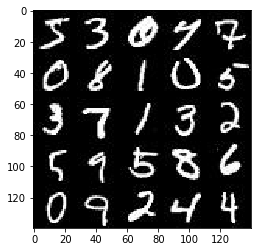

In [236]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

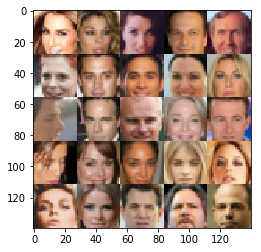

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [143]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels),name='input_real')
    inputs_z = tf.placeholder(tf.float32,(None, z_dim), name='z_dim')
    input_learning_rate = tf.placeholder(tf.float32, name = 'learning_rate') 
    return inputs_real, inputs_z, input_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [223]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input images is 28x28x3
        
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        #14 * 14 * 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #7 * 7 * 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #4 * 4 * 256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
#        print('from dis')
#        print(out)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [224]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator',reuse=not is_train):
        # First fully connected layer
        
        x1 = tf.layers.dense(z, 3*3*256)
        x1 = tf.reshape(x1, (-1, 3, 3, 256))#这里-1是为了自动匹配
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #4* 4 * 256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7 * 7 * 128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)    
        #14 * 14 * 64
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        
        out = tf.tanh(logits)    
#        print('from gen')
#        print(out)
    return out 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [225]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    

    g_model = generator(input_z, out_channel_dim=out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(images=input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    
    d_loss = d_loss_real + d_loss_fake
  
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [226]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [227]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [239]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
#    saver = tf.train.Saver()
#    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
#    saver = tf.train.Saver()
    input_real, input_z, input_learning_rate = model_inputs(image_height=data_shape[1],image_width=data_shape[2], image_channels=data_shape[3], z_dim=z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, out_channel_dim=data_shape[3]) 
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, input_learning_rate, beta1)
    samples, losses = [], []
    steps = 0    

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
#                x1 = tf.reshape(x1, (-1, 4, 4, 256))
                #batch_images = np.reshape(batch_images,(batch_size,28,28,1))

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers 
#                print(data_shape)


                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate:learning_rate})
                

                if steps % 10 == 0:
                    
                    
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = sess.run(g_loss, {input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(steps+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100  == 0:

                    _ = show_generator_output(sess,image_mode=data_image_mode, input_z=input_z, 
                                                       n_images=12,out_channel_dim=data_shape[3])
                    
            
#        saver.save(sess, './checkpoints/generator.ckpt') 

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples             
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 11/2... Discriminator Loss: 0.5672... Generator Loss: 5.0838
Epoch 21/2... Discriminator Loss: 0.9978... Generator Loss: 2.0803
Epoch 31/2... Discriminator Loss: 1.6584... Generator Loss: 0.5473
Epoch 41/2... Discriminator Loss: 1.3757... Generator Loss: 0.7529
Epoch 51/2... Discriminator Loss: 1.0549... Generator Loss: 2.3901
Epoch 61/2... Discriminator Loss: 0.7674... Generator Loss: 4.9683
Epoch 71/2... Discriminator Loss: 1.2128... Generator Loss: 5.6919
Epoch 81/2... Discriminator Loss: 0.5760... Generator Loss: 2.2734
Epoch 91/2... Discriminator Loss: 1.2946... Generator Loss: 0.6990
Epoch 101/2... Discriminator Loss: 0.3495... Generator Loss: 3.3428


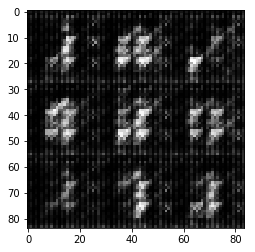

Epoch 111/2... Discriminator Loss: 1.6199... Generator Loss: 0.2652
Epoch 121/2... Discriminator Loss: 0.4633... Generator Loss: 2.6377
Epoch 131/2... Discriminator Loss: 1.5676... Generator Loss: 0.3424
Epoch 141/2... Discriminator Loss: 1.4099... Generator Loss: 1.3720
Epoch 151/2... Discriminator Loss: 0.8284... Generator Loss: 0.8674
Epoch 161/2... Discriminator Loss: 0.4338... Generator Loss: 1.5094
Epoch 171/2... Discriminator Loss: 1.7817... Generator Loss: 0.8838
Epoch 181/2... Discriminator Loss: 0.9857... Generator Loss: 1.0783
Epoch 191/2... Discriminator Loss: 1.0373... Generator Loss: 0.5892
Epoch 201/2... Discriminator Loss: 0.6235... Generator Loss: 1.0500


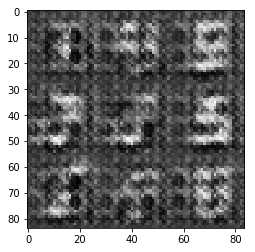

Epoch 211/2... Discriminator Loss: 1.0807... Generator Loss: 0.7679
Epoch 221/2... Discriminator Loss: 1.3665... Generator Loss: 0.6690
Epoch 231/2... Discriminator Loss: 0.6422... Generator Loss: 2.2372
Epoch 241/2... Discriminator Loss: 0.5078... Generator Loss: 1.7689
Epoch 251/2... Discriminator Loss: 1.7002... Generator Loss: 0.3515
Epoch 261/2... Discriminator Loss: 0.5519... Generator Loss: 1.1964
Epoch 271/2... Discriminator Loss: 0.6617... Generator Loss: 1.0759
Epoch 281/2... Discriminator Loss: 0.3528... Generator Loss: 2.1915
Epoch 291/2... Discriminator Loss: 2.2412... Generator Loss: 0.1952
Epoch 301/2... Discriminator Loss: 0.7629... Generator Loss: 1.1104


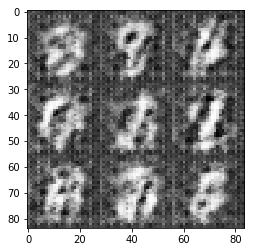

Epoch 311/2... Discriminator Loss: 1.8270... Generator Loss: 4.8453
Epoch 321/2... Discriminator Loss: 0.7364... Generator Loss: 0.9357
Epoch 331/2... Discriminator Loss: 0.1148... Generator Loss: 3.6558
Epoch 341/2... Discriminator Loss: 2.4480... Generator Loss: 1.8496
Epoch 351/2... Discriminator Loss: 1.3175... Generator Loss: 2.2818
Epoch 361/2... Discriminator Loss: 0.9939... Generator Loss: 0.9868
Epoch 371/2... Discriminator Loss: 1.1416... Generator Loss: 2.0233
Epoch 381/2... Discriminator Loss: 1.6310... Generator Loss: 2.5457
Epoch 391/2... Discriminator Loss: 1.2789... Generator Loss: 0.5455
Epoch 401/2... Discriminator Loss: 0.9483... Generator Loss: 2.4565


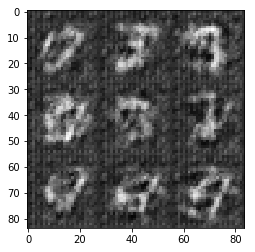

Epoch 411/2... Discriminator Loss: 1.2379... Generator Loss: 0.4963
Epoch 421/2... Discriminator Loss: 0.4310... Generator Loss: 1.7928
Epoch 431/2... Discriminator Loss: 0.8354... Generator Loss: 0.8228
Epoch 441/2... Discriminator Loss: 0.5649... Generator Loss: 1.3748
Epoch 451/2... Discriminator Loss: 1.6254... Generator Loss: 4.6128
Epoch 461/2... Discriminator Loss: 1.2956... Generator Loss: 0.4404
Epoch 471/2... Discriminator Loss: 0.4146... Generator Loss: 1.6899
Epoch 481/2... Discriminator Loss: 0.4561... Generator Loss: 1.8888
Epoch 491/2... Discriminator Loss: 0.6360... Generator Loss: 1.0137
Epoch 501/2... Discriminator Loss: 0.1811... Generator Loss: 2.2916


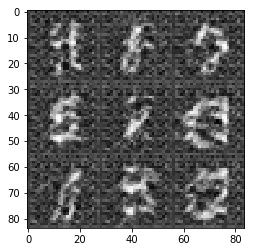

Epoch 511/2... Discriminator Loss: 0.0550... Generator Loss: 4.6570
Epoch 521/2... Discriminator Loss: 0.1921... Generator Loss: 2.2579
Epoch 531/2... Discriminator Loss: 0.2880... Generator Loss: 1.8737
Epoch 541/2... Discriminator Loss: 2.2570... Generator Loss: 0.3818
Epoch 551/2... Discriminator Loss: 0.8612... Generator Loss: 1.5126
Epoch 561/2... Discriminator Loss: 1.0952... Generator Loss: 0.6047
Epoch 571/2... Discriminator Loss: 0.5750... Generator Loss: 1.3051
Epoch 581/2... Discriminator Loss: 1.2270... Generator Loss: 0.4790
Epoch 591/2... Discriminator Loss: 0.7327... Generator Loss: 1.0567
Epoch 601/2... Discriminator Loss: 0.4076... Generator Loss: 1.5689


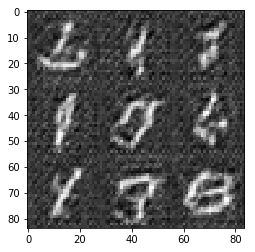

Epoch 611/2... Discriminator Loss: 0.9157... Generator Loss: 2.2843
Epoch 621/2... Discriminator Loss: 0.5601... Generator Loss: 2.0454
Epoch 631/2... Discriminator Loss: 0.4433... Generator Loss: 1.3683
Epoch 641/2... Discriminator Loss: 0.1437... Generator Loss: 2.6224
Epoch 651/2... Discriminator Loss: 0.0968... Generator Loss: 3.1871
Epoch 661/2... Discriminator Loss: 0.0748... Generator Loss: 3.3990
Epoch 671/2... Discriminator Loss: 0.0283... Generator Loss: 5.1719
Epoch 681/2... Discriminator Loss: 0.1368... Generator Loss: 2.6319
Epoch 691/2... Discriminator Loss: 0.0302... Generator Loss: 4.6540
Epoch 701/2... Discriminator Loss: 0.0342... Generator Loss: 5.0333


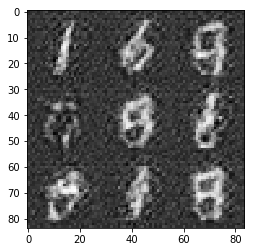

Epoch 711/2... Discriminator Loss: 3.8715... Generator Loss: 6.3233
Epoch 721/2... Discriminator Loss: 1.0945... Generator Loss: 0.8347
Epoch 731/2... Discriminator Loss: 1.3485... Generator Loss: 0.4803
Epoch 741/2... Discriminator Loss: 0.5005... Generator Loss: 1.7883
Epoch 751/2... Discriminator Loss: 0.9783... Generator Loss: 0.6293
Epoch 761/2... Discriminator Loss: 1.0025... Generator Loss: 3.0465
Epoch 771/2... Discriminator Loss: 0.5933... Generator Loss: 1.1276
Epoch 781/2... Discriminator Loss: 0.2263... Generator Loss: 3.7760
Epoch 791/2... Discriminator Loss: 0.1272... Generator Loss: 2.6433
Epoch 801/2... Discriminator Loss: 0.1927... Generator Loss: 2.1051


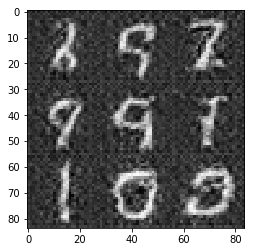

Epoch 811/2... Discriminator Loss: 0.0498... Generator Loss: 3.7073
Epoch 821/2... Discriminator Loss: 0.0623... Generator Loss: 4.1357
Epoch 831/2... Discriminator Loss: 0.2801... Generator Loss: 4.7134
Epoch 841/2... Discriminator Loss: 0.6336... Generator Loss: 1.2630
Epoch 851/2... Discriminator Loss: 0.3947... Generator Loss: 2.2923
Epoch 861/2... Discriminator Loss: 0.4470... Generator Loss: 1.3888
Epoch 871/2... Discriminator Loss: 0.3307... Generator Loss: 5.6939
Epoch 881/2... Discriminator Loss: 0.5979... Generator Loss: 1.3026
Epoch 891/2... Discriminator Loss: 0.4323... Generator Loss: 1.4031
Epoch 901/2... Discriminator Loss: 2.3826... Generator Loss: 4.4490


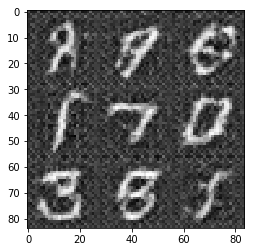

Epoch 911/2... Discriminator Loss: 1.2959... Generator Loss: 2.6896
Epoch 921/2... Discriminator Loss: 0.8361... Generator Loss: 1.5045
Epoch 931/2... Discriminator Loss: 0.5899... Generator Loss: 2.0635
Epoch 941/2... Discriminator Loss: 0.7767... Generator Loss: 3.2239
Epoch 951/2... Discriminator Loss: 0.4793... Generator Loss: 1.4183
Epoch 961/2... Discriminator Loss: 0.3814... Generator Loss: 1.7612
Epoch 971/2... Discriminator Loss: 0.7447... Generator Loss: 3.1665
Epoch 981/2... Discriminator Loss: 0.1623... Generator Loss: 2.7670
Epoch 991/2... Discriminator Loss: 0.2417... Generator Loss: 1.9667
Epoch 1001/2... Discriminator Loss: 0.6328... Generator Loss: 3.7293


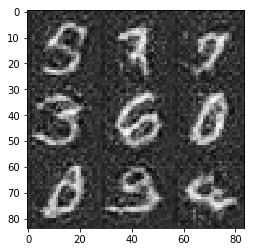

Epoch 1011/2... Discriminator Loss: 0.5809... Generator Loss: 1.5008
Epoch 1021/2... Discriminator Loss: 0.3278... Generator Loss: 2.0375
Epoch 1031/2... Discriminator Loss: 0.4494... Generator Loss: 1.4788
Epoch 1041/2... Discriminator Loss: 0.1618... Generator Loss: 3.0159
Epoch 1051/2... Discriminator Loss: 0.3026... Generator Loss: 1.8450
Epoch 1061/2... Discriminator Loss: 0.0649... Generator Loss: 4.7695
Epoch 1071/2... Discriminator Loss: 0.2384... Generator Loss: 1.8986
Epoch 1081/2... Discriminator Loss: 0.0547... Generator Loss: 3.7541
Epoch 1091/2... Discriminator Loss: 0.0685... Generator Loss: 3.4312
Epoch 1101/2... Discriminator Loss: 0.0795... Generator Loss: 3.1169


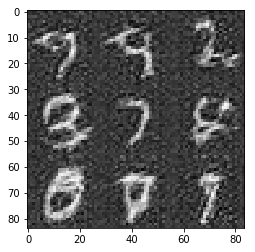

Epoch 1111/2... Discriminator Loss: 0.0588... Generator Loss: 3.3351
Epoch 1121/2... Discriminator Loss: 0.0679... Generator Loss: 3.4255
Epoch 1131/2... Discriminator Loss: 0.0288... Generator Loss: 4.3573
Epoch 1141/2... Discriminator Loss: 0.0145... Generator Loss: 6.3477
Epoch 1151/2... Discriminator Loss: 0.0434... Generator Loss: 3.9741
Epoch 1161/2... Discriminator Loss: 0.9555... Generator Loss: 3.2093
Epoch 1171/2... Discriminator Loss: 0.8735... Generator Loss: 2.9834
Epoch 1181/2... Discriminator Loss: 0.4796... Generator Loss: 1.8358
Epoch 1191/2... Discriminator Loss: 0.5919... Generator Loss: 1.2675
Epoch 1201/2... Discriminator Loss: 0.9000... Generator Loss: 3.8774


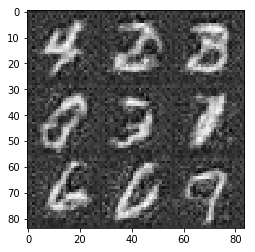

In [241]:
batch_size = 100
z_dim = 100
learning_rate = 0.002
beta1 = 0.5
#image_width =  28
#image_height = 28
#image_channels = 1
alpha = 0.2
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 11/1... Discriminator Loss: 0.1447... Generator Loss: 2.5706
Epoch 21/1... Discriminator Loss: 0.0742... Generator Loss: 3.1995
Epoch 31/1... Discriminator Loss: 0.0639... Generator Loss: 3.3624
Epoch 41/1... Discriminator Loss: 0.0401... Generator Loss: 4.0277
Epoch 51/1... Discriminator Loss: 0.0285... Generator Loss: 4.7991
Epoch 61/1... Discriminator Loss: 5.8483... Generator Loss: 22.0144
Epoch 71/1... Discriminator Loss: 0.4315... Generator Loss: 1.7009
Epoch 81/1... Discriminator Loss: 1.0734... Generator Loss: 9.1435
Epoch 91/1... Discriminator Loss: 0.1325... Generator Loss: 3.0504
Epoch 101/1... Discriminator Loss: 0.1445... Generator Loss: 2.7015


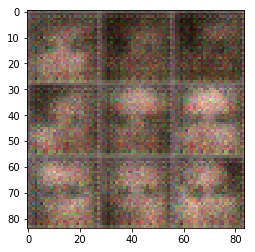

Epoch 111/1... Discriminator Loss: 0.1291... Generator Loss: 4.5696
Epoch 121/1... Discriminator Loss: 0.1625... Generator Loss: 4.7492
Epoch 131/1... Discriminator Loss: 0.0913... Generator Loss: 4.2597
Epoch 141/1... Discriminator Loss: 0.0646... Generator Loss: 3.8755
Epoch 151/1... Discriminator Loss: 0.0533... Generator Loss: 3.8102
Epoch 161/1... Discriminator Loss: 0.0681... Generator Loss: 3.4836
Epoch 171/1... Discriminator Loss: 0.1082... Generator Loss: 6.3424
Epoch 181/1... Discriminator Loss: 0.0875... Generator Loss: 3.1339
Epoch 191/1... Discriminator Loss: 0.1078... Generator Loss: 4.1645
Epoch 201/1... Discriminator Loss: 1.3407... Generator Loss: 9.0250


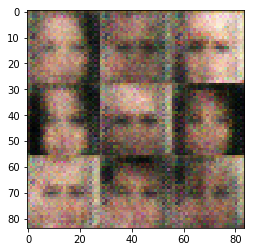

Epoch 211/1... Discriminator Loss: 0.2150... Generator Loss: 2.0923
Epoch 221/1... Discriminator Loss: 0.4637... Generator Loss: 3.6596
Epoch 231/1... Discriminator Loss: 0.3426... Generator Loss: 2.6342
Epoch 241/1... Discriminator Loss: 0.9236... Generator Loss: 0.8872
Epoch 251/1... Discriminator Loss: 0.4740... Generator Loss: 3.8388
Epoch 261/1... Discriminator Loss: 0.3746... Generator Loss: 1.9351
Epoch 271/1... Discriminator Loss: 0.3386... Generator Loss: 1.8637
Epoch 281/1... Discriminator Loss: 0.2104... Generator Loss: 2.6152
Epoch 291/1... Discriminator Loss: 0.1978... Generator Loss: 2.2680
Epoch 301/1... Discriminator Loss: 0.3148... Generator Loss: 2.0222


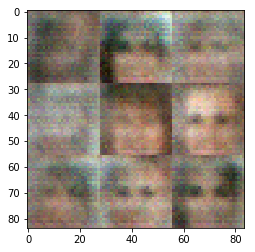

Epoch 311/1... Discriminator Loss: 0.2136... Generator Loss: 2.5754
Epoch 321/1... Discriminator Loss: 0.1680... Generator Loss: 2.6051
Epoch 331/1... Discriminator Loss: 0.4300... Generator Loss: 1.3540
Epoch 341/1... Discriminator Loss: 0.6183... Generator Loss: 2.3687
Epoch 351/1... Discriminator Loss: 0.5145... Generator Loss: 3.0043
Epoch 361/1... Discriminator Loss: 0.3149... Generator Loss: 2.2501
Epoch 371/1... Discriminator Loss: 0.2363... Generator Loss: 3.1603
Epoch 381/1... Discriminator Loss: 0.4121... Generator Loss: 2.8158
Epoch 391/1... Discriminator Loss: 0.3574... Generator Loss: 1.6556
Epoch 401/1... Discriminator Loss: 0.2665... Generator Loss: 2.0322


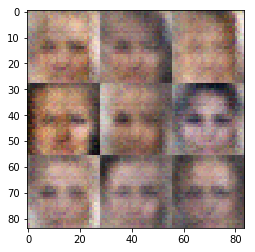

Epoch 411/1... Discriminator Loss: 0.2346... Generator Loss: 2.2518
Epoch 421/1... Discriminator Loss: 0.1228... Generator Loss: 3.0554
Epoch 431/1... Discriminator Loss: 0.3980... Generator Loss: 6.3733
Epoch 441/1... Discriminator Loss: 0.2392... Generator Loss: 2.0564
Epoch 451/1... Discriminator Loss: 0.2414... Generator Loss: 3.6242
Epoch 461/1... Discriminator Loss: 0.2537... Generator Loss: 5.2027
Epoch 471/1... Discriminator Loss: 0.0861... Generator Loss: 3.7750
Epoch 481/1... Discriminator Loss: 0.2520... Generator Loss: 4.7960
Epoch 491/1... Discriminator Loss: 0.0525... Generator Loss: 6.2720
Epoch 501/1... Discriminator Loss: 0.1618... Generator Loss: 2.9341


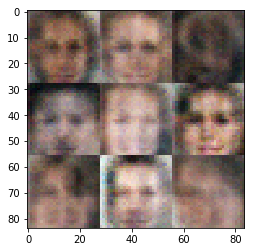

Epoch 511/1... Discriminator Loss: 0.1572... Generator Loss: 3.1038
Epoch 521/1... Discriminator Loss: 0.2178... Generator Loss: 2.1645
Epoch 531/1... Discriminator Loss: 0.1408... Generator Loss: 4.1554
Epoch 541/1... Discriminator Loss: 0.2086... Generator Loss: 2.4683
Epoch 551/1... Discriminator Loss: 0.2107... Generator Loss: 2.1562
Epoch 561/1... Discriminator Loss: 0.0566... Generator Loss: 5.9012
Epoch 571/1... Discriminator Loss: 0.0880... Generator Loss: 3.6876
Epoch 581/1... Discriminator Loss: 0.2336... Generator Loss: 2.3769
Epoch 591/1... Discriminator Loss: 0.1007... Generator Loss: 3.3919
Epoch 601/1... Discriminator Loss: 0.0614... Generator Loss: 4.1866


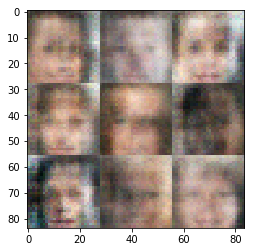

Epoch 611/1... Discriminator Loss: 0.0781... Generator Loss: 3.1314
Epoch 621/1... Discriminator Loss: 0.6322... Generator Loss: 8.9999
Epoch 631/1... Discriminator Loss: 0.3185... Generator Loss: 1.7599
Epoch 641/1... Discriminator Loss: 0.0562... Generator Loss: 6.5980
Epoch 651/1... Discriminator Loss: 0.1147... Generator Loss: 3.2101
Epoch 661/1... Discriminator Loss: 1.0377... Generator Loss: 0.5830
Epoch 671/1... Discriminator Loss: 1.3748... Generator Loss: 0.4744
Epoch 681/1... Discriminator Loss: 0.1998... Generator Loss: 2.7850
Epoch 691/1... Discriminator Loss: 0.1295... Generator Loss: 2.9025
Epoch 701/1... Discriminator Loss: 0.1378... Generator Loss: 2.7141


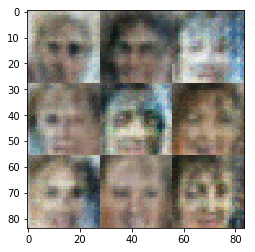

Epoch 711/1... Discriminator Loss: 0.1993... Generator Loss: 2.2983
Epoch 721/1... Discriminator Loss: 0.4012... Generator Loss: 1.6446
Epoch 731/1... Discriminator Loss: 0.2192... Generator Loss: 3.9390
Epoch 741/1... Discriminator Loss: 0.1294... Generator Loss: 3.0592
Epoch 751/1... Discriminator Loss: 0.0943... Generator Loss: 3.7700
Epoch 761/1... Discriminator Loss: 0.0742... Generator Loss: 3.9855
Epoch 771/1... Discriminator Loss: 0.1555... Generator Loss: 5.8439
Epoch 781/1... Discriminator Loss: 0.0910... Generator Loss: 3.1347
Epoch 791/1... Discriminator Loss: 0.1763... Generator Loss: 3.8727
Epoch 801/1... Discriminator Loss: 0.3883... Generator Loss: 1.6275


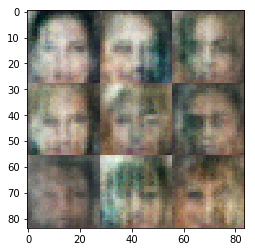

Epoch 811/1... Discriminator Loss: 0.5177... Generator Loss: 1.3144
Epoch 821/1... Discriminator Loss: 0.2584... Generator Loss: 3.1162
Epoch 831/1... Discriminator Loss: 0.1366... Generator Loss: 2.9882
Epoch 841/1... Discriminator Loss: 0.0960... Generator Loss: 3.2414
Epoch 851/1... Discriminator Loss: 0.2449... Generator Loss: 1.8842
Epoch 861/1... Discriminator Loss: 0.6260... Generator Loss: 5.9093
Epoch 871/1... Discriminator Loss: 0.5876... Generator Loss: 1.4860
Epoch 881/1... Discriminator Loss: 0.2771... Generator Loss: 3.0310
Epoch 891/1... Discriminator Loss: 0.2312... Generator Loss: 2.5485
Epoch 901/1... Discriminator Loss: 0.1273... Generator Loss: 3.4437


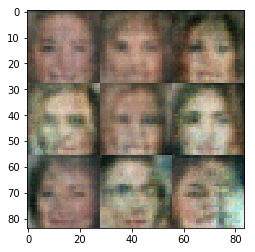

Epoch 911/1... Discriminator Loss: 0.1260... Generator Loss: 3.1633
Epoch 921/1... Discriminator Loss: 0.0954... Generator Loss: 3.5984
Epoch 931/1... Discriminator Loss: 0.2965... Generator Loss: 1.9116
Epoch 941/1... Discriminator Loss: 0.1520... Generator Loss: 2.4655
Epoch 951/1... Discriminator Loss: 0.0953... Generator Loss: 3.8921
Epoch 961/1... Discriminator Loss: 0.0607... Generator Loss: 4.1741
Epoch 971/1... Discriminator Loss: 0.0895... Generator Loss: 2.9913
Epoch 981/1... Discriminator Loss: 4.0988... Generator Loss: 11.9136
Epoch 991/1... Discriminator Loss: 0.3253... Generator Loss: 2.8966
Epoch 1001/1... Discriminator Loss: 0.3699... Generator Loss: 1.7722


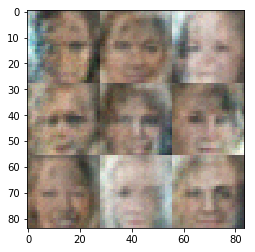

Epoch 1011/1... Discriminator Loss: 0.2691... Generator Loss: 2.0674
Epoch 1021/1... Discriminator Loss: 0.4181... Generator Loss: 1.4022
Epoch 1031/1... Discriminator Loss: 0.1627... Generator Loss: 3.6495
Epoch 1041/1... Discriminator Loss: 0.1489... Generator Loss: 3.5468
Epoch 1051/1... Discriminator Loss: 0.0899... Generator Loss: 3.8239
Epoch 1061/1... Discriminator Loss: 0.0632... Generator Loss: 4.1536
Epoch 1071/1... Discriminator Loss: 0.0530... Generator Loss: 4.6211
Epoch 1081/1... Discriminator Loss: 0.0950... Generator Loss: 5.3280
Epoch 1091/1... Discriminator Loss: 0.2103... Generator Loss: 2.1710
Epoch 1101/1... Discriminator Loss: 0.4791... Generator Loss: 1.2419


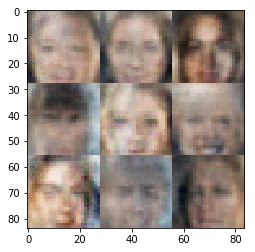

Epoch 1111/1... Discriminator Loss: 0.1660... Generator Loss: 4.9014
Epoch 1121/1... Discriminator Loss: 0.2062... Generator Loss: 5.1683
Epoch 1131/1... Discriminator Loss: 0.0543... Generator Loss: 3.9661
Epoch 1141/1... Discriminator Loss: 0.8179... Generator Loss: 0.9106
Epoch 1151/1... Discriminator Loss: 0.4485... Generator Loss: 1.4667
Epoch 1161/1... Discriminator Loss: 0.1596... Generator Loss: 3.0138
Epoch 1171/1... Discriminator Loss: 0.1939... Generator Loss: 2.2283
Epoch 1181/1... Discriminator Loss: 0.1656... Generator Loss: 2.5615
Epoch 1191/1... Discriminator Loss: 0.1622... Generator Loss: 2.6209
Epoch 1201/1... Discriminator Loss: 0.0957... Generator Loss: 4.0168


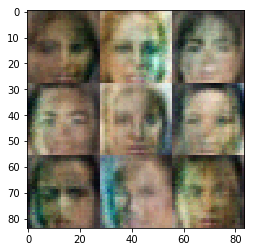

Epoch 1211/1... Discriminator Loss: 0.1131... Generator Loss: 3.4098
Epoch 1221/1... Discriminator Loss: 0.0813... Generator Loss: 3.2259
Epoch 1231/1... Discriminator Loss: 0.1425... Generator Loss: 3.2817
Epoch 1241/1... Discriminator Loss: 0.1674... Generator Loss: 2.9379
Epoch 1251/1... Discriminator Loss: 0.1734... Generator Loss: 3.0713
Epoch 1261/1... Discriminator Loss: 0.0778... Generator Loss: 3.5434
Epoch 1271/1... Discriminator Loss: 0.0780... Generator Loss: 4.5670
Epoch 1281/1... Discriminator Loss: 1.5038... Generator Loss: 0.3571
Epoch 1291/1... Discriminator Loss: 0.8316... Generator Loss: 0.8298
Epoch 1301/1... Discriminator Loss: 0.5336... Generator Loss: 2.5517


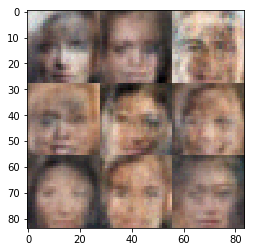

Epoch 1311/1... Discriminator Loss: 0.4397... Generator Loss: 1.4191
Epoch 1321/1... Discriminator Loss: 0.1465... Generator Loss: 3.5062
Epoch 1331/1... Discriminator Loss: 0.0759... Generator Loss: 3.8815
Epoch 1341/1... Discriminator Loss: 0.7057... Generator Loss: 6.2048
Epoch 1351/1... Discriminator Loss: 0.0802... Generator Loss: 5.3251
Epoch 1361/1... Discriminator Loss: 3.4274... Generator Loss: 9.1513
Epoch 1371/1... Discriminator Loss: 0.3472... Generator Loss: 1.7090
Epoch 1381/1... Discriminator Loss: 1.1768... Generator Loss: 0.4607
Epoch 1391/1... Discriminator Loss: 0.1034... Generator Loss: 3.0154
Epoch 1401/1... Discriminator Loss: 0.0616... Generator Loss: 4.9591


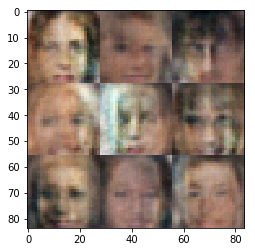

Epoch 1411/1... Discriminator Loss: 4.6438... Generator Loss: 11.9677
Epoch 1421/1... Discriminator Loss: 0.2269... Generator Loss: 2.2401
Epoch 1431/1... Discriminator Loss: 0.0958... Generator Loss: 3.4733
Epoch 1441/1... Discriminator Loss: 0.0651... Generator Loss: 3.6446
Epoch 1451/1... Discriminator Loss: 0.1406... Generator Loss: 4.8884
Epoch 1461/1... Discriminator Loss: 0.0438... Generator Loss: 5.3545
Epoch 1471/1... Discriminator Loss: 0.0694... Generator Loss: 3.3807
Epoch 1481/1... Discriminator Loss: 0.0839... Generator Loss: 3.2626
Epoch 1491/1... Discriminator Loss: 1.9836... Generator Loss: 9.6189
Epoch 1501/1... Discriminator Loss: 0.7008... Generator Loss: 1.0028


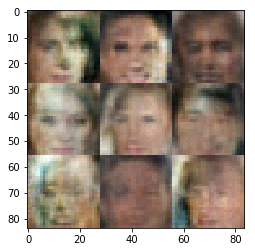

Epoch 1511/1... Discriminator Loss: 0.3673... Generator Loss: 2.5497
Epoch 1521/1... Discriminator Loss: 0.2524... Generator Loss: 2.6673
Epoch 1531/1... Discriminator Loss: 0.1928... Generator Loss: 2.7299
Epoch 1541/1... Discriminator Loss: 0.2323... Generator Loss: 2.0554
Epoch 1551/1... Discriminator Loss: 0.2566... Generator Loss: 1.9391
Epoch 1561/1... Discriminator Loss: 0.1972... Generator Loss: 2.2995
Epoch 1571/1... Discriminator Loss: 0.1322... Generator Loss: 2.9904
Epoch 1581/1... Discriminator Loss: 0.0947... Generator Loss: 3.3426
Epoch 1591/1... Discriminator Loss: 0.2054... Generator Loss: 2.1658
Epoch 1601/1... Discriminator Loss: 0.5390... Generator Loss: 1.2364


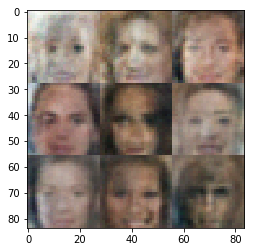

Epoch 1611/1... Discriminator Loss: 0.0472... Generator Loss: 4.4585
Epoch 1621/1... Discriminator Loss: 0.3989... Generator Loss: 1.4849
Epoch 1631/1... Discriminator Loss: 0.0801... Generator Loss: 3.3195
Epoch 1641/1... Discriminator Loss: 0.2038... Generator Loss: 2.1054
Epoch 1651/1... Discriminator Loss: 0.0722... Generator Loss: 4.4040
Epoch 1661/1... Discriminator Loss: 0.0552... Generator Loss: 7.5654
Epoch 1671/1... Discriminator Loss: 0.1000... Generator Loss: 3.3968
Epoch 1681/1... Discriminator Loss: 0.2895... Generator Loss: 1.7953
Epoch 1691/1... Discriminator Loss: 0.1414... Generator Loss: 2.7951
Epoch 1701/1... Discriminator Loss: 0.1024... Generator Loss: 4.6704


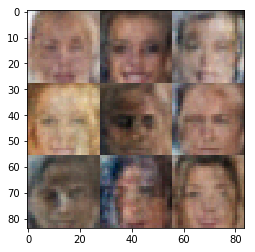

Epoch 1711/1... Discriminator Loss: 0.0335... Generator Loss: 6.2119
Epoch 1721/1... Discriminator Loss: 1.5462... Generator Loss: 0.4924
Epoch 1731/1... Discriminator Loss: 0.1922... Generator Loss: 2.4195
Epoch 1741/1... Discriminator Loss: 0.1231... Generator Loss: 3.5520
Epoch 1751/1... Discriminator Loss: 0.0956... Generator Loss: 3.1938
Epoch 1761/1... Discriminator Loss: 0.0955... Generator Loss: 3.0703
Epoch 1771/1... Discriminator Loss: 0.0908... Generator Loss: 3.8005
Epoch 1781/1... Discriminator Loss: 0.0341... Generator Loss: 4.4647
Epoch 1791/1... Discriminator Loss: 0.0385... Generator Loss: 4.8572
Epoch 1801/1... Discriminator Loss: 0.1241... Generator Loss: 2.7459


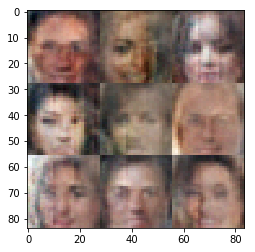

Epoch 1811/1... Discriminator Loss: 0.0773... Generator Loss: 4.4475
Epoch 1821/1... Discriminator Loss: 0.0981... Generator Loss: 5.3655
Epoch 1831/1... Discriminator Loss: 0.0974... Generator Loss: 3.7271
Epoch 1841/1... Discriminator Loss: 0.0408... Generator Loss: 4.3469
Epoch 1851/1... Discriminator Loss: 0.2281... Generator Loss: 1.9737
Epoch 1861/1... Discriminator Loss: 0.0221... Generator Loss: 5.2483
Epoch 1871/1... Discriminator Loss: 0.7590... Generator Loss: 3.3553
Epoch 1881/1... Discriminator Loss: 0.4513... Generator Loss: 1.8760
Epoch 1891/1... Discriminator Loss: 0.2986... Generator Loss: 2.1040
Epoch 1901/1... Discriminator Loss: 0.1938... Generator Loss: 2.6581


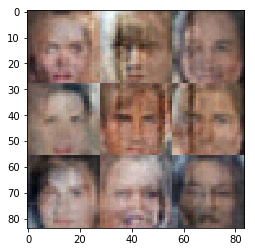

Epoch 1911/1... Discriminator Loss: 0.2109... Generator Loss: 2.3372
Epoch 1921/1... Discriminator Loss: 0.1927... Generator Loss: 2.2245
Epoch 1931/1... Discriminator Loss: 0.0837... Generator Loss: 3.1881
Epoch 1941/1... Discriminator Loss: 0.0663... Generator Loss: 3.5261
Epoch 1951/1... Discriminator Loss: 0.1178... Generator Loss: 2.9654
Epoch 1961/1... Discriminator Loss: 0.0997... Generator Loss: 3.3782
Epoch 1971/1... Discriminator Loss: 0.0589... Generator Loss: 4.6485
Epoch 1981/1... Discriminator Loss: 0.0899... Generator Loss: 3.2236
Epoch 1991/1... Discriminator Loss: 0.0387... Generator Loss: 4.4796
Epoch 2001/1... Discriminator Loss: 0.1338... Generator Loss: 2.9302


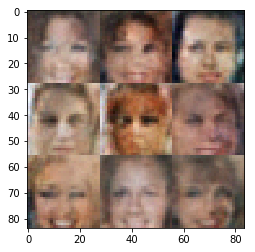

Epoch 2011/1... Discriminator Loss: 0.0581... Generator Loss: 3.6767
Epoch 2021/1... Discriminator Loss: 0.0823... Generator Loss: 3.7973


In [244]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。